In [3]:
# Install required packages
!pip install -q transformers datasets evaluate rouge-score accelerate

print("✓ All packages installed!")

  Preparing metadata (setup.py) ... done
✓ All packages installed!


In [4]:
"""
BART Summarization - Imports
"""

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, Dataset
from transformers import (
    BartTokenizer,
    BartForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
import evaluate

# Check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print("\n🎉 All imports successful!")

Device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB

🎉 All imports successful!


In [5]:
# Load CNN/DailyMail dataset
print("Loading CNN/DailyMail dataset...")
dataset = load_dataset("cnn_dailymail", "3.0.0")

# Select subset (adjust size as needed)
train_dataset = dataset["train"].select(range(10000))  # 10K for good results
val_dataset = dataset["validation"].select(range(1000))
test_dataset = dataset["test"].select(range(500))

print(f"\nDataset loaded:")
print(f"  Train: {len(train_dataset)}")
print(f"  Validation: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")

# Show sample
print(f"\n{'='*80}")
print("SAMPLE DATA")
print(f"{'='*80}")
print(f"\nArticle (first 300 chars):\n{train_dataset[0]['article'][:300]}...")
print(f"\nSummary:\n{train_dataset[0]['highlights']}")

Loading CNN/DailyMail dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

3.0.0/train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

3.0.0/validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

3.0.0/test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]


Dataset loaded:
  Train: 10000
  Validation: 1000
  Test: 500

SAMPLE DATA

Article (first 300 chars):
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappoi...

Summary:
Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .


In [6]:
# Initialize tokenizer
model_checkpoint = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_checkpoint)

max_input_length = 1024
max_target_length = 128

def preprocess_function(examples):
    """Tokenize articles and summaries"""
    model_inputs = tokenizer(
        examples["article"],
        max_length=max_input_length,
        truncation=True,
        padding=False
    )

    labels = tokenizer(
        text_target=examples["highlights"],
        max_length=max_target_length,
        truncation=True,
        padding=False
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize datasets
print("Tokenizing datasets...")
tokenized_train = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
tokenized_val = val_dataset.map(preprocess_function, batched=True, remove_columns=val_dataset.column_names)
tokenized_test = test_dataset.map(preprocess_function, batched=True, remove_columns=test_dataset.column_names)

print("✓ Preprocessing complete!")

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Tokenizing datasets...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

✓ Preprocessing complete!


In [15]:
# Load model
print("Loading BART model...")
model = BartForConditionalGeneration.from_pretrained(model_checkpoint, attn_implementation="eager")

# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=-100
)

# ROUGE metric
rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    """Compute ROUGE scores"""
    predictions, labels = eval_pred

    # Replace potential NaN values with pad_token_id
    # Then, ensure predictions are valid integer token IDs within the vocabulary range
    predictions = np.where(np.isnan(predictions), tokenizer.pad_token_id, predictions)
    predictions = np.where(
        (predictions < 0) | (predictions >= tokenizer.vocab_size),
        tokenizer.pad_token_id,
        predictions
    ).astype(int)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = ["\n".join(pred.split(".")) for pred in decoded_preds]
    decoded_labels = ["\n".join(label.split(".")) for label in decoded_labels]

    result = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    return {k: round(v * 100, 4) for k, v in result.items()}

print("✓ Model and metrics ready!")

Loading BART model...
✓ Model and metrics ready!


In [8]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./bart-cnn-summarization",
    eval_strategy="steps", # Corrected argument name for evaluation strategy
    logging_strategy="steps",
    eval_steps=500,
    save_steps=500,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    generation_max_length=max_target_length,
    generation_num_beams=4,
    fp16=True,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    greater_is_better=True,
    push_to_hub=False,
    report_to="none"
)

In [9]:
# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    processing_class=tokenizer, # Changed from tokenizer=tokenizer
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("✓ Trainer configured!")
print(f"\nExpected training time on GPU: ~30-45 minutes")

✓ Trainer configured!

Expected training time on GPU: ~30-45 minutes


In [10]:
# Start training
print("="*80)
print("STARTING TRAINING")
print("="*80)

trainer.train()

print("\n✓ Training complete!")

# Save model
trainer.save_model("./bart-finetuned-cnn")
tokenizer.save_pretrained("./bart-finetuned-cnn")
print("✓ Model saved!")

STARTING TRAINING


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
500,2.120900,2.148889,31.892000,12.058200,22.401700,29.305000
1000,1.891500,2.084761,31.779900,11.792800,22.197200,29.173400
1500,1.676900,2.106919,31.682700,11.550200,22.175100,29.130900


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].



✓ Training complete!
✓ Model saved!


In [11]:
# Evaluate on test set
print("Evaluating on test set...")
test_results = trainer.evaluate(tokenized_test, metric_key_prefix="test")

print("\n" + "="*80)
print("TEST SET RESULTS")
print("="*80)
for key, value in test_results.items():
    if "rouge" in key:
        print(f"{key:20s}: {value:6.2f}")

Evaluating on test set...



TEST SET RESULTS
test_rouge1         :  32.52
test_rouge2         :  12.56
test_rougeL         :  23.35
test_rougeLsum      :  29.93


### Steps to use the saved model:

In [21]:
# 1. Load the fine-tuned model and tokenizer
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

model_path = "./bart-finetuned-cnn"

print(f"Loading tokenizer from {model_path}...")
loaded_tokenizer = BartTokenizer.from_pretrained(model_path)
print(f"Loading model from {model_path}...")
loaded_model = BartForConditionalGeneration.from_pretrained(model_path).to(device)

print("✓ Model and tokenizer loaded successfully!")

Loading tokenizer from ./bart-finetuned-cnn...
Loading model from ./bart-finetuned-cnn...
✓ Model and tokenizer loaded successfully!


### 2. Define the `generate_summary` function (if not already defined or if you're in a new session):

*(Note: This function is already present in a previous cell, but it's included here for completeness if you were to restart your Colab session or run this in a new notebook.)*

In [22]:
# This is the same generate_summary function as before, just using the 'loaded_model' and 'loaded_tokenizer'
def generate_summary_with_loaded_model(article, model, tokenizer):
    model.eval()
    inputs = tokenizer(article, max_length=1024, truncation=True, return_tensors="pt").to(model.device)

    with torch.no_grad():
        summary_ids = model.generate(
            inputs["input_ids"],
            num_beams=4,
            max_length=128,
            min_length=30,
            length_penalty=2.0,
            early_stopping=True,
            no_repeat_ngram_size=3
        )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("✓ generate_summary_with_loaded_model function defined!")

✓ generate_summary_with_loaded_model function defined!


### 3. Use the loaded model to generate a summary for a new article:

Let's pick an example article from the test set or use a custom one.

In [23]:
new_article = test_dataset[5]["article"] # Using another article from the test set
# You can also use your own article, e.g.:
# new_article = """Your custom long article text here. Make sure it's sufficiently long for summarization."""

print("Generating summary for the new article...")
generated_summary_new = generate_summary_with_loaded_model(new_article, loaded_model, loaded_tokenizer)

print(f"\n{'='*80}")
print("NEW ARTICLE SUMMARY")
print(f"{'='*80}")
print(f"\nARTICLE (first 400 chars):\n{new_article[:400]}...\n")
print(f"REFERENCE (if available):\n{test_dataset[5]['highlights']}\n") # If using test_dataset
print(f"GENERATED SUMMARY:\n{generated_summary_new}\n")

Generating summary for the new article...

NEW ARTICLE SUMMARY

ARTICLE (first 400 chars):
(CNN)He's a blue chip college basketball recruit. She's a high school freshman with Down syndrome. At first glance Trey Moses and Ellie Meredith couldn't be more different. But all that changed Thursday when Trey asked Ellie to be his prom date. Trey -- a star on Eastern High School's basketball team in Louisville, Kentucky, who's headed to play college ball next year at Ball State -- was original...

REFERENCE (if available):
College-bound basketball star asks girl with Down syndrome to high school prom .
Pictures of the two during the "prom-posal" have gone viral .

GENERATED SUMMARY:
Trey Moses asked Ellie Meredith to be his prom date .
He's a star on Eastern High School's basketball team in Louisville, Kentucky .
"She's great... she listens and she's easy to talk to," he says .
Trey is looking to take up special education as a college major .



In [24]:
# Generate sample summaries
def generate_summary(article, model, tokenizer):
    model.eval()
    inputs = tokenizer(article, max_length=1024, truncation=True, return_tensors="pt").to(model.device)

    with torch.no_grad():
        summary_ids = model.generate(
            inputs["input_ids"],
            num_beams=4,
            max_length=128,
            min_length=30,
            length_penalty=2.0,
            early_stopping=True,
            no_repeat_ngram_size=3
        )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Test on samples
print("="*80)
print("SAMPLE SUMMARIES")
print("="*80)

for i in range(3):
    print(f"\n{'='*80}")
    print(f"EXAMPLE {i+1}")
    print('='*80)

    article = test_dataset[i]["article"]
    reference = test_dataset[i]["highlights"]
    generated = generate_summary(article, model, tokenizer)

    print(f"\nARTICLE (first 400 chars):\n{article[:400]}...\n")
    print(f"REFERENCE:\n{reference}\n")
    print(f"GENERATED:\n{generated}\n")

SAMPLE SUMMARIES

EXAMPLE 1

ARTICLE (first 400 chars):
(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also acce...

REFERENCE:
Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June .
Israel and the United States opposed the move, which could open the door to war crimes investigations against Israelis .

GENERATED:
(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherla

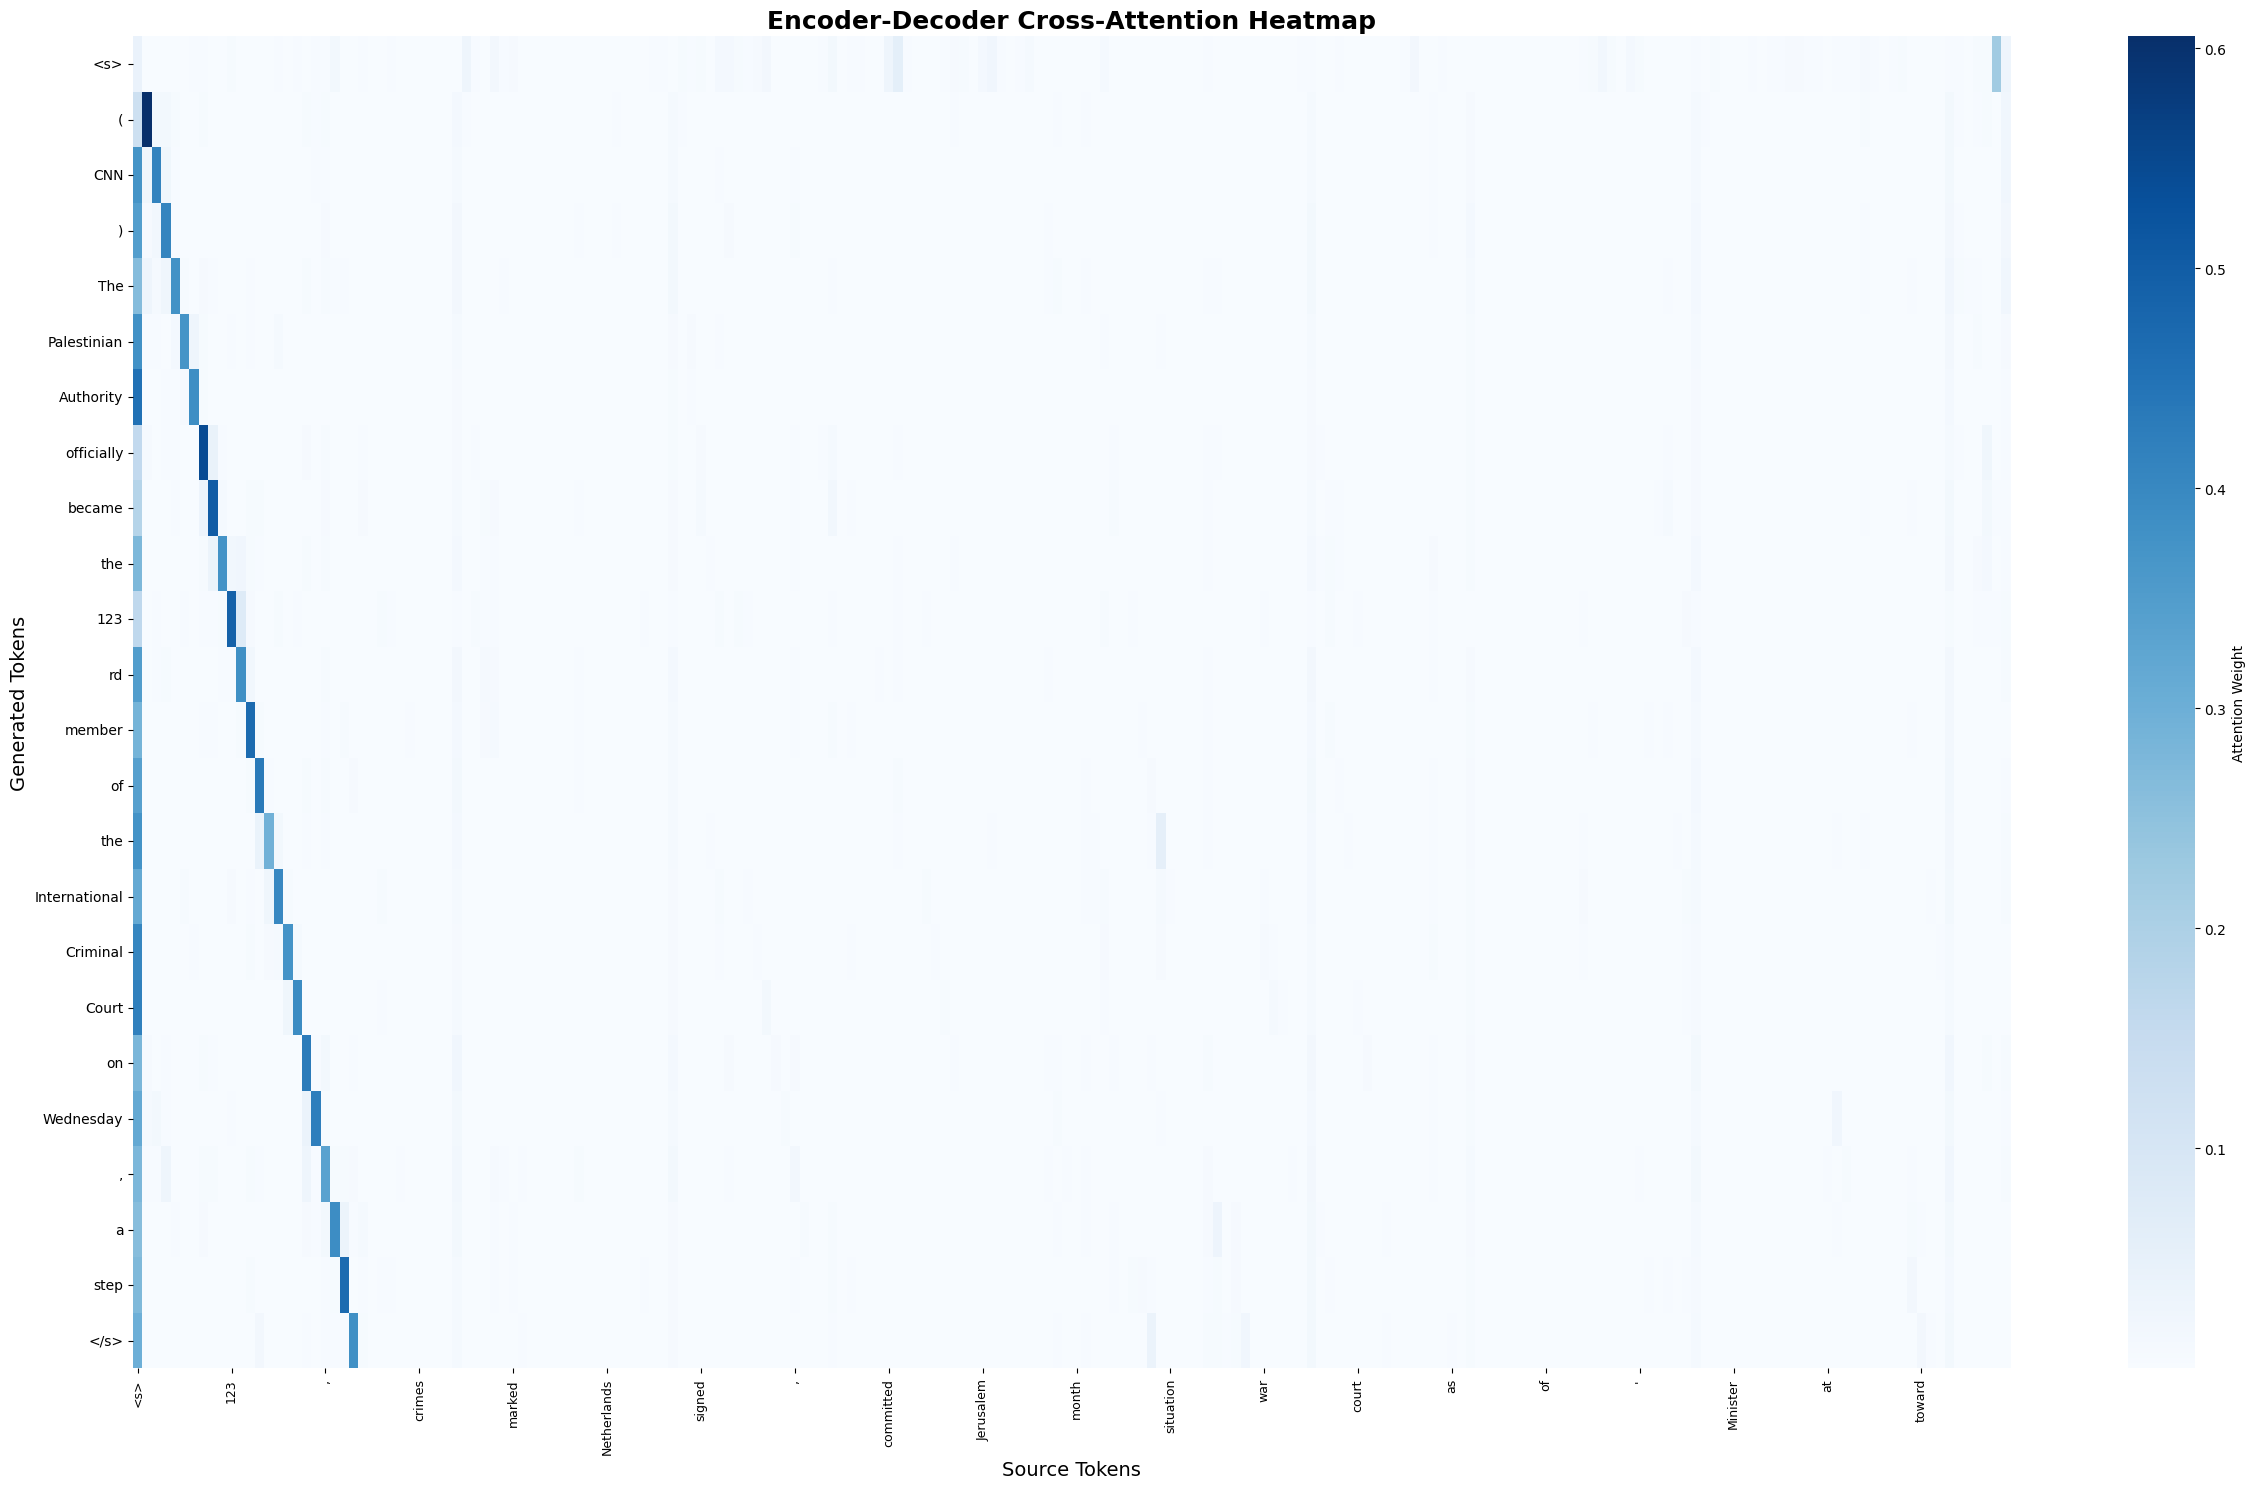

In [25]:
# Visualize attention
def visualize_attention_heatmap(article, model, tokenizer, max_gen_length=25, max_src_length=200):
    model.eval()

    inputs = tokenizer(article, max_length=max_src_length, truncation=True, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            max_length=max_gen_length,
            num_beams=1,
            output_attentions=True,
            return_dict_in_generate=True
        )

    # Collect attention
    cross_attentions = outputs.cross_attentions
    attention_matrix = []

    for step in range(len(cross_attentions)):
        # cross_attentions[step] contains attention weights for each decoder layer at this step
        # For cross-attention, it's usually (batch_size, num_heads, 1, src_len) for the current generated token
        # We want the last layer's attention, averaged over heads, for the first (and only) generated token
        attn = cross_attentions[step][-1][0].mean(dim=0)[0].cpu().numpy()
        attention_matrix.append(attn)

    attention_matrix = np.array(attention_matrix)

    # Get tokens
    input_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    output_tokens = tokenizer.convert_ids_to_tokens(outputs.sequences[0][1:len(cross_attentions)+1])

    # Prepare x-axis labels: remove 'Ġ' and sample for readability
    num_input_tokens = len(input_tokens)
    num_output_tokens = len(output_tokens)

    # Determine x-axis tick frequency to avoid overcrowding
    # Sample roughly 20 labels, adjust interval dynamically
    x_sample_interval = max(1, num_input_tokens // 20)
    x_tick_labels = [input_tokens[i].replace('Ġ', '') for i in range(0, num_input_tokens, x_sample_interval)]
    x_tick_positions = [i + 0.5 for i in range(0, num_input_tokens, x_sample_interval)] # +0.5 to center ticks

    # Prepare y-axis labels: remove 'Ġ'
    y_tick_labels = [token.replace('Ġ', '') for token in output_tokens]
    y_tick_positions = [i + 0.5 for i in range(num_output_tokens)] # +0.5 to center ticks

    # Plot
    plt.figure(figsize=(25, 15)) # Increased figure size
    sns.heatmap(
        attention_matrix,
        cmap="Blues", # Changed colormap to 'Blues'
        cbar_kws={'label': 'Attention Weight'},
        xticklabels=False, # Disable auto labels from heatmap
        yticklabels=False # Disable auto labels from heatmap
    )

    # Set custom xticks and labels
    plt.xticks(x_tick_positions, x_tick_labels, rotation=90, ha='center', fontsize=9)
    plt.yticks(y_tick_positions, y_tick_labels, rotation=0, va='center', fontsize=10)


    plt.xlabel("Source Tokens", fontsize=14)
    plt.ylabel("Generated Tokens", fontsize=14)
    plt.title("Encoder-Decoder Cross-Attention Heatmap", fontsize=18, fontweight='bold') # Increased title font size
    plt.tight_layout()
    plt.show()

    return attention_matrix

# Visualize sample
sample_article = test_dataset[0]["article"]
attention_matrix = visualize_attention_heatmap(sample_article, model, tokenizer)

The heatmap visualizes the encoder-decoder cross-attention weights. It helps us understand which parts of the original article the model is focusing on when it generates each word of the summary.

### Interpretation:

- X-axis (horizontal): Represents the source tokens from the input article. Each column corresponds to a word or subword token from the article.

- Y-axis (vertical): Represents the generated tokens from the summary. Each row corresponds to a word or subword token as the model generates the summary, in sequential order.

- Color Intensity: The color in each cell indicates the attention weight. Brighter or more intense colors (e.g., redder in a YlOrRd colormap) mean that the generated token on the Y-axis is paying more attention to the source token on the X-axis. Conversely, lighter colors indicate less attention.
What to look for and what it tells us:

- Bright Horizontal Lines/Spots: If you see a bright spot or a concentrated horizontal line across a few source tokens for a specific generated token (on the Y-axis), it means that generated word is heavily influenced by those specific words in the article. This often indicates information extraction or direct copying from the source.

- Diagonal Patterns: Sometimes, you might observe diagonal patterns, especially at the beginning of the summary. This can suggest that the model is processing the input sequentially and pulling information in a relatively ordered fashion.
Attention to Key Information: For a summarization task, ideally, we want to see higher attention weights on the most important keywords, entities, and phrases in the source article. This shows the model is successfully identifying and leveraging the salient information.

- Less Attention to Stop Words: As we discussed, words like 'the', 'a', 'is' might appear in the source. You would generally expect to see lower attention weights assigned to these less informative tokens, indicating the model has learned to filter them out when generating the summary.

- Synthesis vs. Extraction: A heatmap can give clues if the model is primarily extracting sentences/phrases (more concentrated attention) or synthesizing new sentences (more diffuse attention across multiple parts of the source).
In essence, it's a visual diagnostic tool to peek into the model's 'thought process' and understand why it generated a particular summary word by word, by showing what it was 'looking at' in the original text.

In [14]:
from google.colab import files
!zip -r bart-finetuned-cnn.zip bart-finetuned-cnn/
files.download('bart-finetuned-cnn.zip')

  adding: bart-finetuned-cnn/ (stored 0%)
  adding: bart-finetuned-cnn/vocab.json (deflated 68%)
  adding: bart-finetuned-cnn/merges.txt (deflated 53%)
  adding: bart-finetuned-cnn/tokenizer_config.json (deflated 75%)
  adding: bart-finetuned-cnn/model.safetensors (deflated 7%)
  adding: bart-finetuned-cnn/generation_config.json (deflated 44%)
  adding: bart-finetuned-cnn/special_tokens_map.json (deflated 85%)
  adding: bart-finetuned-cnn/config.json (deflated 64%)
  adding: bart-finetuned-cnn/training_args.bin (deflated 53%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### How does encoder-decoder attention help in generating high-quality summaries in models like BART?

- Encoder-decoder attention (also known as cross-attention) is fundamental to how sequence-to-sequence models like BART generate high-quality summaries. Here's how it helps:

- Selective Information Extraction: It allows the decoder (the part of the model generating the summary) to selectively focus on specific parts of the input article (processed by the encoder) at each step of generating a new word for the summary. Instead of trying to compress the entire source into a single fixed-size vector, the decoder can dynamically retrieve relevant information from the source.

- Contextual Grounding: Each word generated in the summary can be directly linked back to its origin in the source article. This grounding helps prevent the model from 'hallucinating' (generating information not present in the original text) and ensures the summary is factual and relevant to the source.
Handling Long Dependencies: In summarization, the output (summary) often depends on widely separated parts of the input (article). Encoder-decoder attention efficiently manages these long-range dependencies, ensuring that even if a key piece of information appeared early in the article, it can still be attended to when needed to generate a summary word much later.

- Conciseness and Relevance: By dynamically weighing the importance of different source tokens, the model can extract the most salient information and discard less important details, contributing directly to the conciseness and relevance required for a good summary.

- Coherence and Fluency: By understanding which parts of the input contribute to the current generated token, the model can ensure that the summary flows logically and maintains grammatical correctness.

### How does encoder-decoder attention differ from self-attention, and why is this distinction important for summarization?

- The key difference lies in what sequences are being attended to:

- Self-Attention: In self-attention, a sequence attends to itself.

- In the Encoder: Each word in the input article (e.g., "Harry Potter is famous") attends to all other words in the same article to understand the context and relationships between them (e.g., "Harry Potter" is the subject of "is famous"). This helps the encoder build a rich, contextualized representation of the entire source article.

- In the Decoder: Each word generated so far in the summary (e.g., "Harry Potter gets") attends to all previously generated words in the summary to maintain coherence and consistency within the summary itself (e.g., ensuring grammatical flow and factual consistency as the summary unfolds).
Query, Key, Value: All come from the same sequence.

- Encoder-Decoder Attention (Cross-Attention): This is where the decoder attends to the encoder's output.

- Purpose: It acts as a bridge, allowing the decoder to look at the encoded representations of the original article while it is generating the summary. For each word the decoder is about to produce, it queries the full context of the source article provided by the encoder.

- Query: Comes from the decoder's current input (the hidden state corresponding to the word being generated, combined with previously generated words via self-attention).

- Key, Value: Come from the encoder's output (the contextualized representations of the source article tokens).

*Why this distinction is important for summarization:*

- This distinction is crucial because it directly enables the core task of summarization: generating new text based on existing source text.

- Self-attention is vital for understanding the internal coherence of both the input article (encoder self-attention) and the generated summary (decoder self-attention).

- Encoder-decoder attention is what allows the model to transfer information from the source to the target. Without it, the decoder would effectively be generating text blindly, based only on what it has produced so far, with no direct way to consult the original document. This cross-attention mechanism is precisely how the BART model decides which parts of the input article are most relevant to include or rephrase when formulating each word of the output summary.

## Summary of What I did

- Environment Setup: Installed necessary libraries (transformers, datasets, evaluate, rouge-score, accelerate).

- Data Preparation: Loaded the CNN/DailyMail dataset, selected subsets for training, validation, and testing, and tokenized them using BartTokenizer.

- Model Training: Initialized BartForConditionalGeneration, configured Seq2SeqTrainingArguments, and trained the model using Seq2SeqTrainer.

- Model Evaluation: Evaluated the fine-tuned model on the test set using ROUGE metrics.

- Attention Visualization: Implemented and improved a function to visualize encoder-decoder cross-attention using a heatmap, helping to understand which parts of the article the model focuses on during summary generation.

- Conceptual Understanding: Discussed the role of encoder-decoder attention in high-quality summarization and differentiated it from self-attention.

- Model Deployment: Provided clear steps to load the saved fine-tuned model and tokenizer, and demonstrated how to generate new summaries.
